<a href="https://colab.research.google.com/github/nitinrajg/ML-Projects/blob/main/Student_performance_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Environment Setup & Dependencies**

In [1]:
# Install required packages
!pip install -q pandas numpy matplotlib seaborn plotly scikit-learn xgboost shap

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

# Display settings
import pandas as pd
pd.set_option('display.max_columns', None)

# Set seed for reproducibility
import numpy as np
np.random.seed(42)


## **Data Acquisition & Loading**

In [2]:
# Download the student dataset (from UCI ML repository)
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip -O student.zip
!unzip -o student.zip

# Load both Math and Portuguese datasets
df_math = pd.read_csv('student-mat.csv', sep=';')
df_por = pd.read_csv('student-por.csv', sep=';')

# Combine both datasets for a richer sample
df = pd.concat([df_math, df_por], ignore_index=True)

# Confirm dataset shape and preview
print("Dataset shape:", df.shape)
df.head()

Archive:  student.zip
  inflating: student-mat.csv         
  inflating: student-por.csv         
  inflating: student-merge.R         
  inflating: student.txt             
Dataset shape: (1044, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## **Data Exploration & Profiling**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

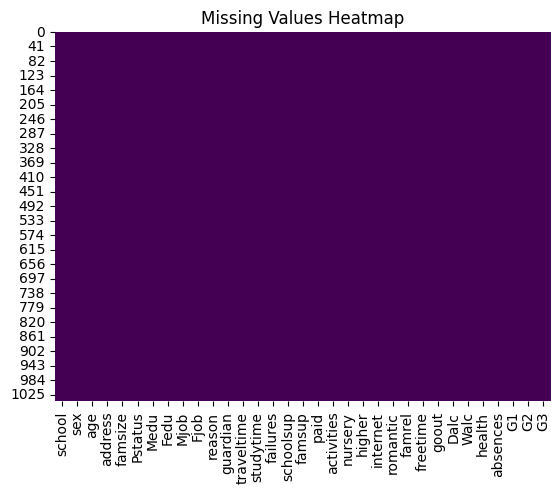

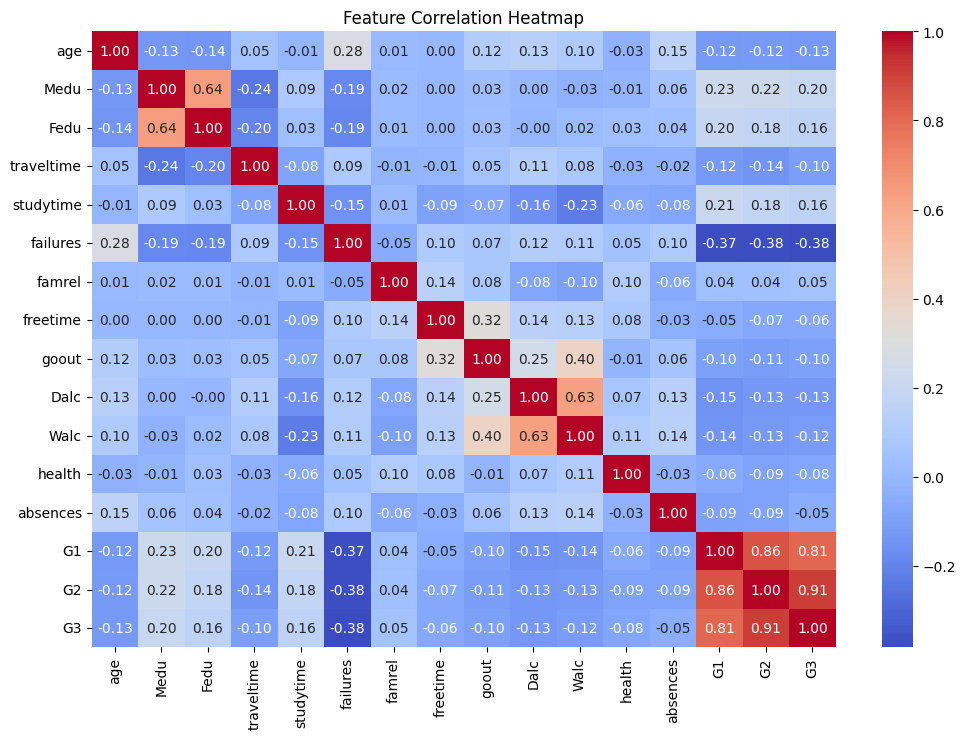

In [3]:
# View basic dataset structure
df.info()

# Descriptive statistics
df.describe()

# Check for missing values
df.isnull().sum()

# Visualize missing values (if any)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Correlation heatmap between numeric features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## **Data Preprocessing Pipeline**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode all categorical features
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Define input and target
X = df.drop('G3', axis=1)  # Features
y = df['G3']               # Target (final grade)

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Feature Engineering**

In [5]:
# Create interaction and derived features
df['studytime_failures'] = df['studytime'] * df['failures']
df['absences_ratio'] = df['absences'] / (df['absences'].max() + 1)

# View new features
df[['studytime_failures', 'absences_ratio']].head()

,studytime_failures,absences_ratio
0,0,0.078947
1,0,0.052632
2,6,0.131579
3,0,0.026316
4,0,0.052632


## **Exploratory Data Analysis (EDA)**

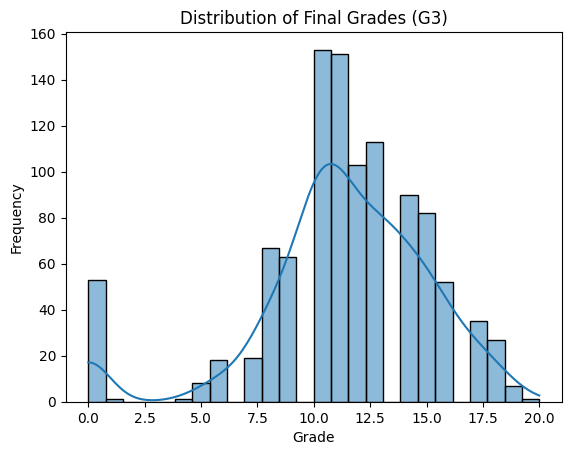

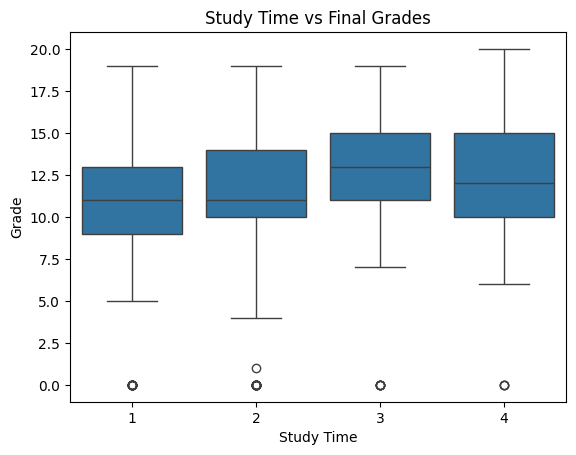

In [6]:
# Grade distribution
sns.histplot(y, kde=True)
plt.title("Distribution of Final Grades (G3)")
plt.xlabel("Grade")
plt.ylabel("Frequency")
plt.show()

# Study time vs performance
sns.boxplot(x=df['studytime'], y=df['G3'])
plt.title("Study Time vs Final Grades")
plt.xlabel("Study Time")
plt.ylabel("Grade")
plt.show()


## **Model Development & Training**

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Train all models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} training complete.")

Linear Regression training complete.
Random Forest training complete.
XGBoost training complete.


## **Model Evaluation & Comparison**

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate each model's performance
for name, model in models.items():
    preds = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
    print(f"R²: {r2_score(y_test, preds):.2f}")


Linear Regression Performance:
MAE: 1.04
RMSE: 1.78
R²: 0.80

Random Forest Performance:
MAE: 0.96
RMSE: 1.71
R²: 0.81

XGBoost Performance:
MAE: 1.08
RMSE: 1.82
R²: 0.79


## **Model Interpretation & Explainability**

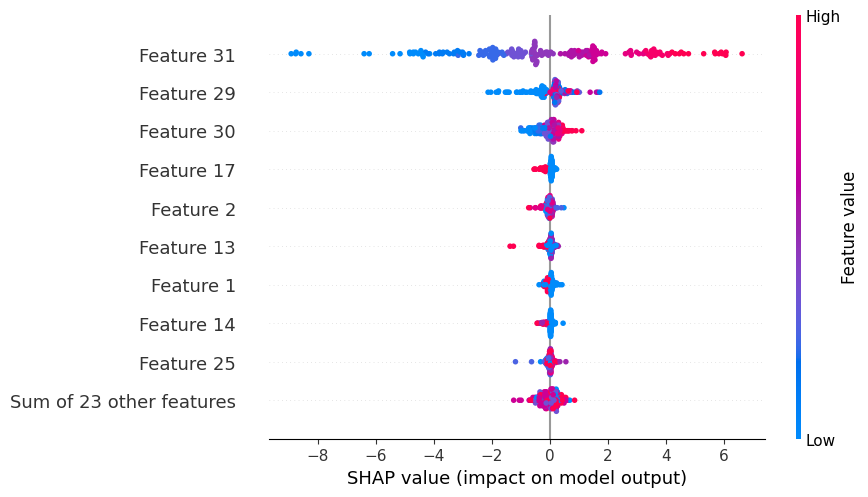

In [10]:
import shap

# SHAP explainability for XGBoost
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)

# Feature importance visualization
shap.plots.beeswarm(shap_values)


## **Model Deployment Preparation**

In [11]:
import joblib

# Save the trained model
joblib.dump(models["XGBoost"], "student_perf_model.pkl")

# Sample inference
sample = X_test[0].reshape(1, -1)
pred = models["XGBoost"].predict(sample)
print("Sample Prediction:", pred[0])


Sample Prediction: 9.597563
